# Rekonstruktion eines 3d Bildes aus einer Serie von Schattenbildern

Wir versuchen, aus Schattenbildern eines Objekts (aufgenommen aus unterschiedlichen Winkeln) die 3D-Struktur des Objekts zu rekonstruieren. Das hier ist das aufgenommene Objekt:

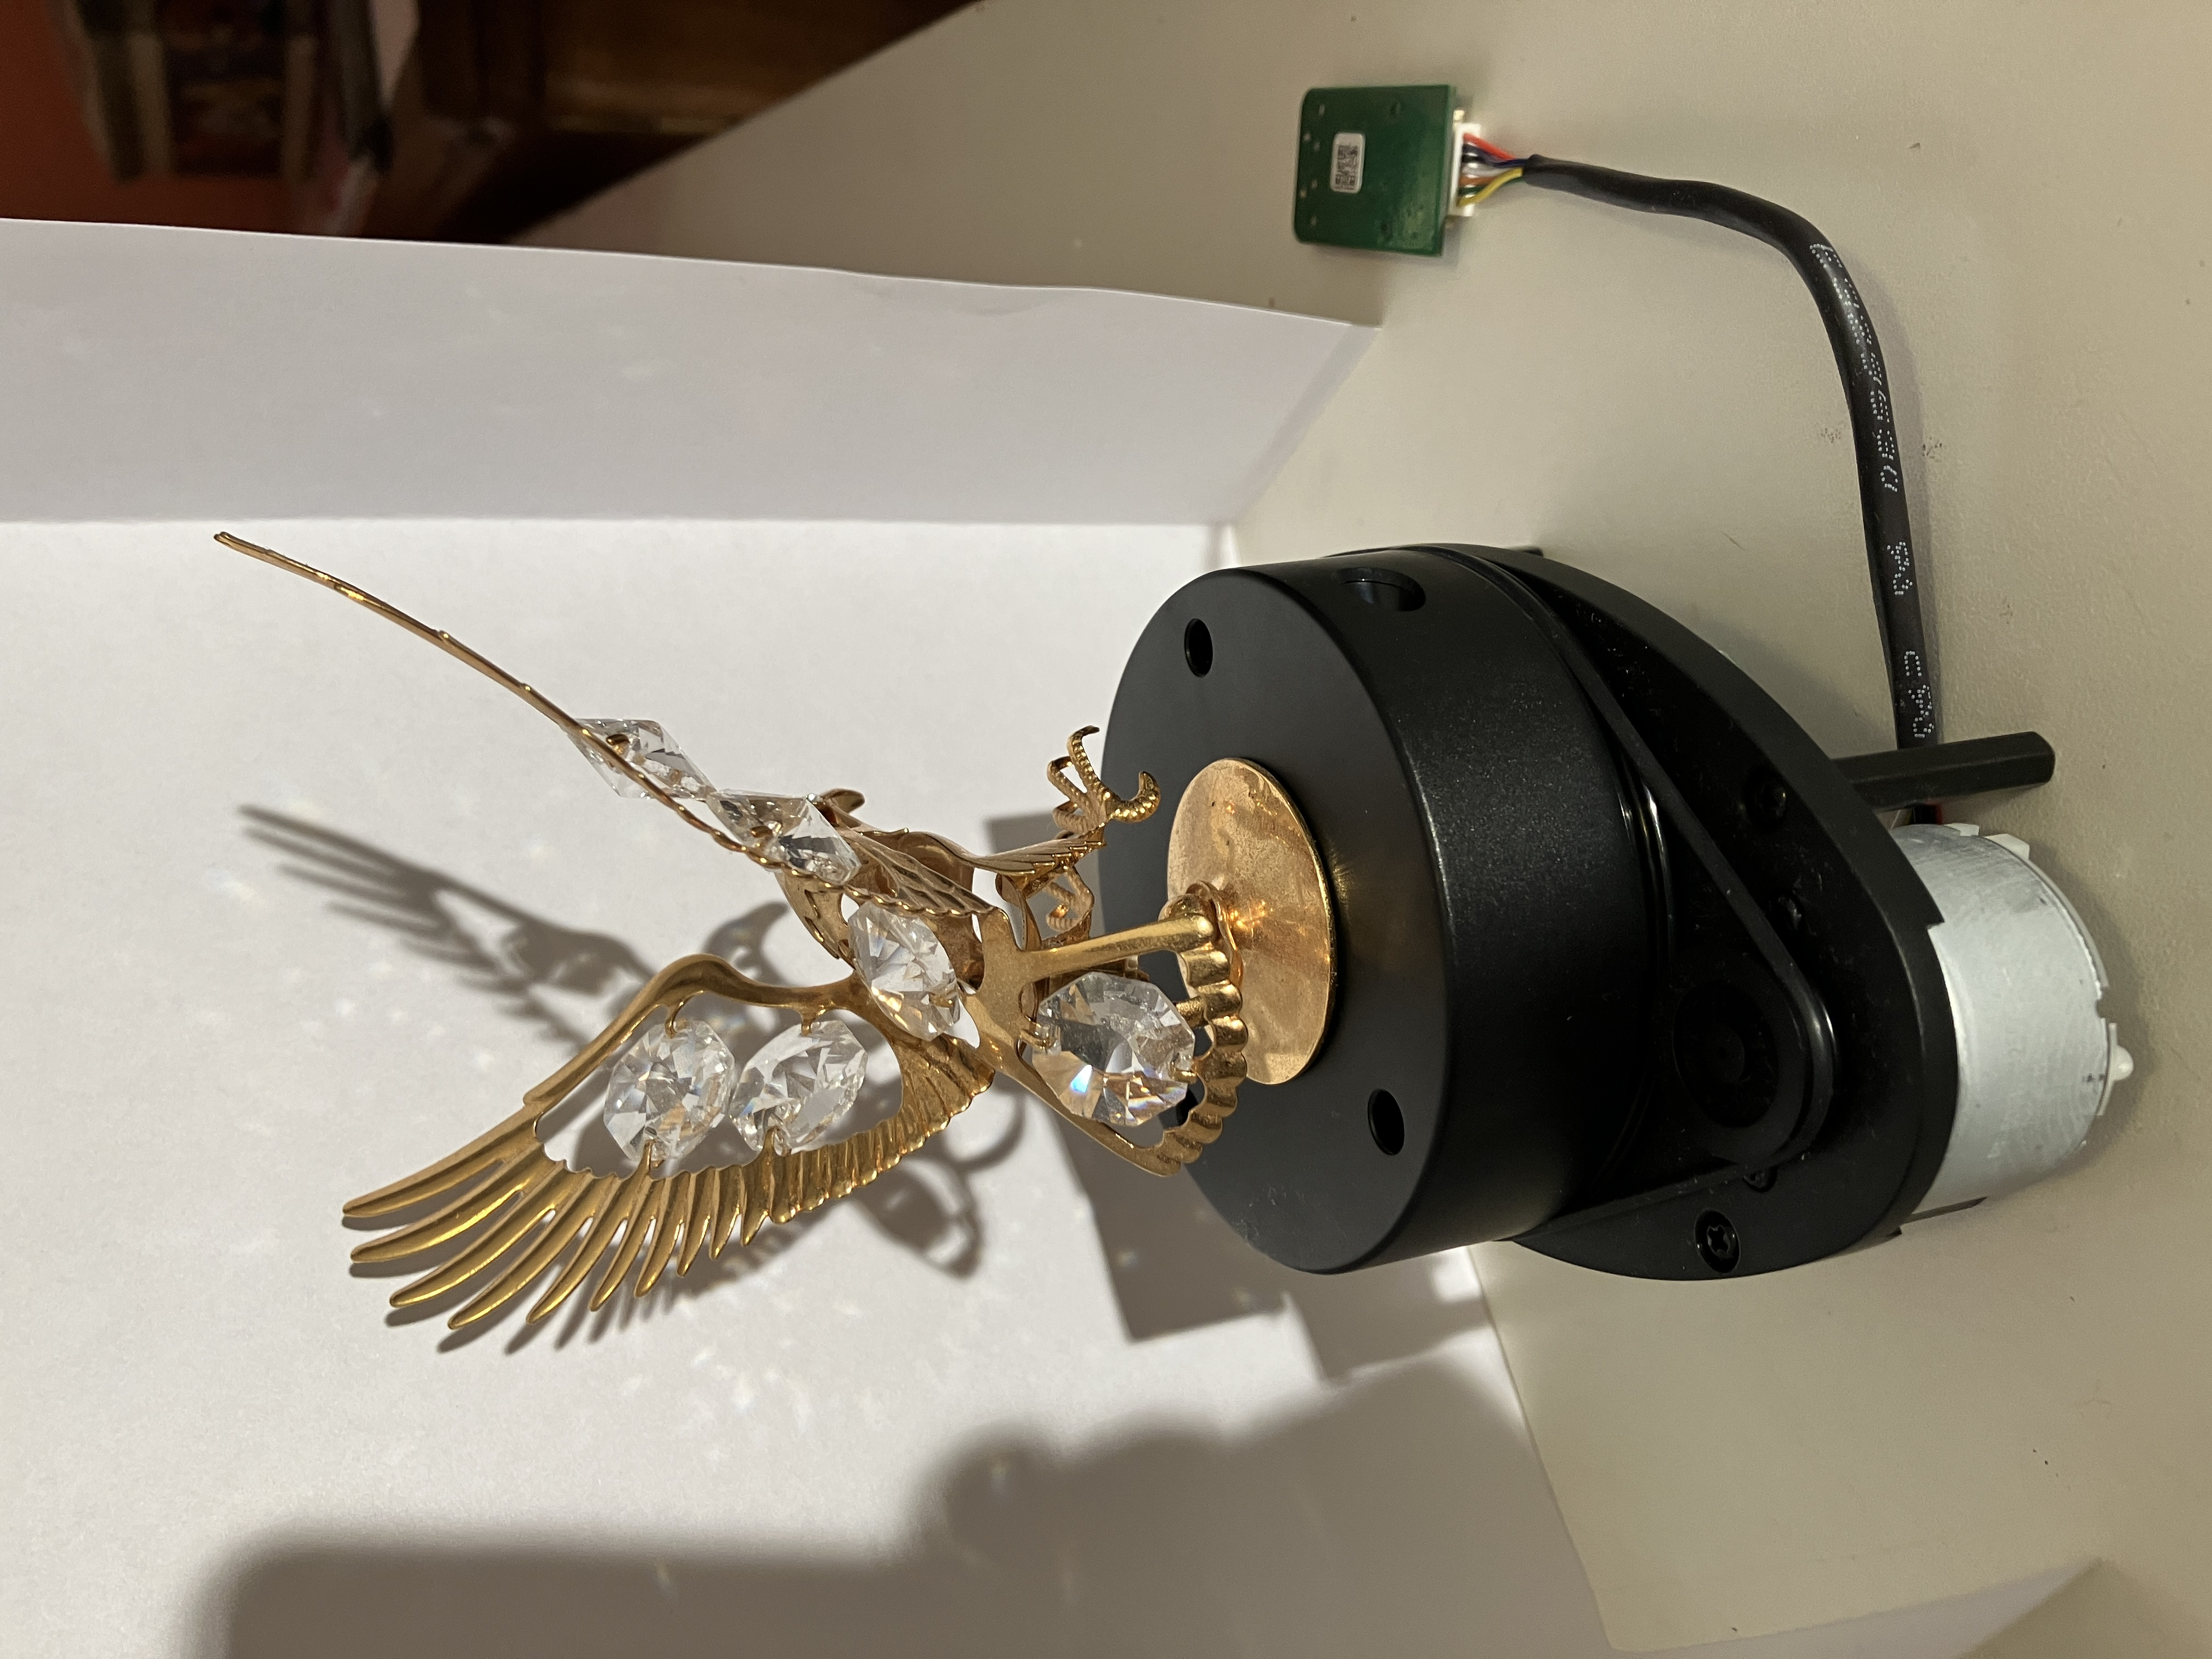

In [1]:
from IPython.display import Image as Im
import os
Im(filename='IMG_0032.JPG', width=400)

Das hier sind die aufgenommenen Schattenbilder:

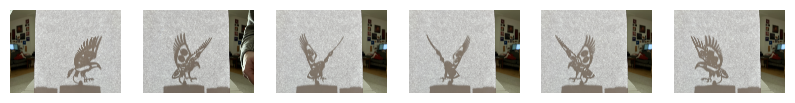

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
os.chdir("source images")
image_files = ['IMG_0035.JPG',
               'IMG_0036.JPG',
               'IMG_0037.JPG',
               'IMG_0038.JPG',
               'IMG_0039.JPG',
               'IMG_0040.JPG']

from matplotlib.pyplot import axis, figure, imshow
from matplotlib.image import imread
import numpy as np

order = np.array([5,0,1,2,3,4])
fig = figure()
number_of_files = len(image_files)
for i in range(number_of_files):
    a=fig.add_subplot(1, number_of_files, i+1)
    k=order[i]
    image = imread(image_files[order[i]])
    if(k!=5):
        imshow(np.flip(image,1))
    if(i==0):
        imshow(image)
    axis("off")

## Preprocessing

In [3]:
from PIL import Image
rotations = [0., 30., 60., 90., 120., 150.]
images = [Image.open(filename) for filename in image_files]

Originales Schattenbild

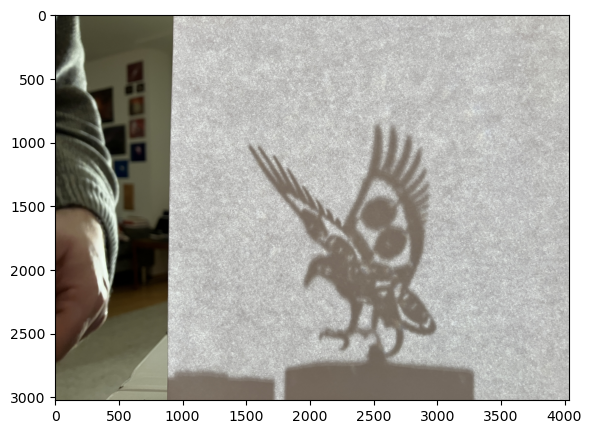

In [4]:
from IPython.display import display
from PIL import Image
plt.imshow(images[0])
plt.show()

### Crop

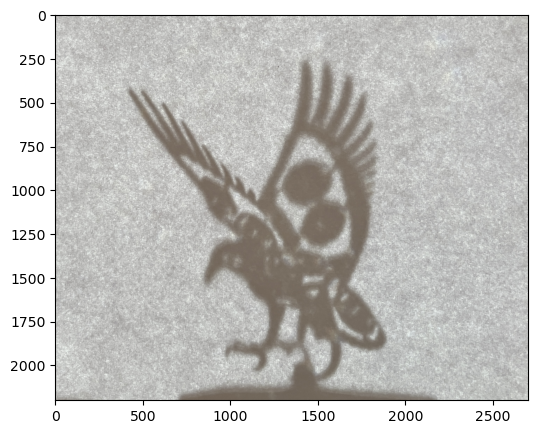

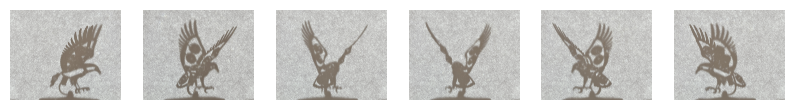

In [5]:
cropped_images = [i.copy().crop((1100, 600, 3800, 2800)) for i in images]
plt.imshow(cropped_images[0])
plt.show()
cropped_images[0].size

order = np.array([5,0,1,2,3,4])
fig = figure()
number_of_files = len(image_files)
for i in range(number_of_files):
    a=fig.add_subplot(1, number_of_files, i+1)
    image = cropped_images[order[i]]
    if(i!=0):
        imshow(np.flip(image,1))
    if(i==0):
        imshow(image)
    axis("off")

os.chdir("../result")    
plt.savefig("Originalaufnahmen",bbox_inches='tight')

### Threshold

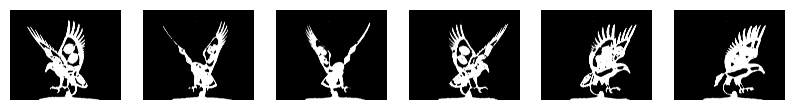

In [6]:
threshold = 140

binary_images = [i.copy().convert("L").point(lambda p: 0 if p > threshold else 255).convert("1") for i in cropped_images]

fig = figure()
for i in range(number_of_files):
    a=fig.add_subplot(1, number_of_files, i+1)
    image = binary_images[i]
    imshow(image)
    axis("off")

### Dilation

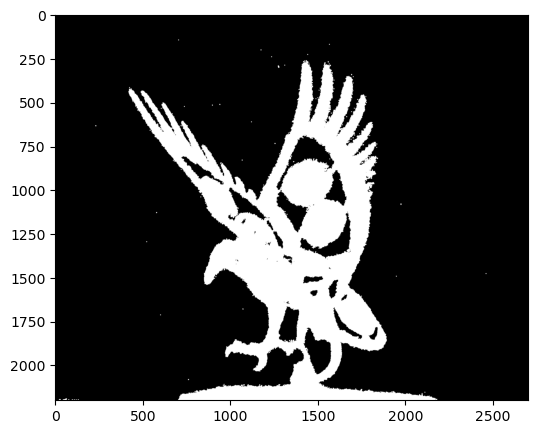

In [7]:
from PIL import ImageFilter
dilated_images = [i.copy().filter(ImageFilter.MaxFilter(5)) for i in binary_images]
plt.imshow(dilated_images[0])
plt.show()

### Auflösung verringern

C:\Users\cheng\AppData\Local\Temp\ipykernel_17428\4249857150.py:2: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  shrunk_images = [i.copy().resize(tuple([s // shrink_factor for s in i.size]), Image.LANCZOS) for i in dilated_images]


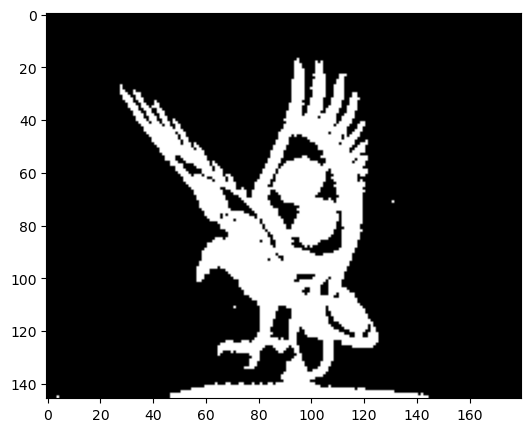

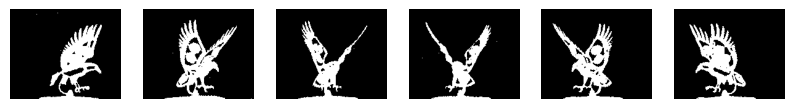

In [8]:
shrink_factor = 15
shrunk_images = [i.copy().resize(tuple([s // shrink_factor for s in i.size]), Image.LANCZOS) for i in dilated_images]
plt.imshow(shrunk_images[0])
plt.show()
dim = max(shrunk_images[0].size)
dim

order = np.array([5,0,1,2,3,4])
fig = figure()
number_of_files = len(image_files)
for i in range(number_of_files):
    a=fig.add_subplot(1, number_of_files, i+1)
    image = shrunk_images[order[i]]
    if(i!=0):
        imshow(Image.fromarray(np.flip(image,1)))
    if(i==0):
        imshow(image)
    axis("off")

os.chdir("../result") 
plt.savefig("Schattenbilder",bbox_inches='tight')

## Processing

### Das erste Bild (das mit der Nummer 0) wird in den Raum extrudiert.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors

%matplotlib notebook
import numpy as np
os.chdir("../result")

i=np.array(shrunk_images[0])
extruded = np.empty((dim, dim, dim), dtype=bool)
intersect = np.empty((dim, dim, dim), dtype=bool)


intersect.fill(False)
extruded.fill(False)

normal_vector = np.array([0., 0., 1.])

for idx, x in np.ndenumerate(i):
    if x:
        origin = np.array([idx[0], idx[1], 0])
        for p in range(dim):
            coo = (origin + p * normal_vector).astype(int)
            coo2 = np.array([coo[1],coo[2],dim-coo[0]-1])
            extruded[tuple(coo2)] = True


intersect = extruded.copy()


### Die übrigen Bilder werden sukzessive unter dem jeweiligen Aufnahmewinkel extrudiert und der Schnitt aus allen extrudierten Bildern erzeugt. Dieser Kern ist die 3d-Rekonstruktion

In [10]:
from math import cos, sin, radians, degrees, tan
%matplotlib notebook


order = np.array([1,2,3,4,5])

for l in range(0,number_of_files-1):
    k=order[l]
    angle = rotations[k]

    i = np.array(shrunk_images[k])
    extruded01 = np.empty((dim,dim,dim), dtype=bool)
    extruded01.fill(False)
    

    normal_vector = np.array([0., -sin(radians(angle)), cos(radians(angle))])

    for pmax in range(-int(dim/2)+1,-int(dim/2),-1):
        x0=dim/2.
        z0=dim/2.
        
#        intersect_col = np.empty((dim,dim,dim), dtype=object)
        extruded01.fill(False)

        for idx, x in np.ndenumerate(i):
            if x:
                origin = np.array([idx[0],(x0+(idx[1]-x0)*cos(radians(angle))),(z0+(idx[1]-x0)*sin(radians(angle)))])
                origin2 = (origin + pmax * normal_vector).astype(int)
                for p in range(int(dim/2.),pmax,-1):
                    coo = (origin + p * normal_vector).astype(int)
                    #coo2 = (origin - p * normal_vector).astype(int)
                    coo2 = np.array([coo[1],coo[2],dim-coo[0]-1])
                    if 0<=coo[0] and coo[0]<dim and 0<=coo[1] and coo[1]<dim and 0<=coo[2] and coo[2]<dim and x:
                        extruded01[tuple(coo2)] = True
                    
    #Bildlücken entfernen, indem das Bild 1Pkt in x-y- und z-Richtung verschoben und auf sich selbst gestempelt wird
        extruded01=np.logical_or(extruded01,np.roll(extruded01,1,axis=0))
        extruded01=np.logical_or(extruded01,np.roll(extruded01,1,axis=1))
        extruded01=np.logical_or(extruded01,np.roll(extruded01,1,axis=2))
    
#Die bisherige 3d-Rekonstruktion mit dem nächsten extrudierten Schattenbild schneiden:  
        intersect=np.logical_and(intersect,extruded01)



### Die 3d-Rekonstruktion aus allen Perspektiven darstellen und die Bilder speichern:

In [ ]:
count_azim=0
for azim in range(120,-240,-10):
    fig03 = plt.figure()
    ay = fig03.add_subplot(projection='3d')
    ay.azim=azim
    ay.elev=5
    bbox = fig03.bbox_inches.from_bounds(3.35, 1.3, 3.6, 2.3)
    ay.voxels(intersect,facecolors = 'red')
    ay.axes.xaxis.set_ticklabels([])
    ay.axes.yaxis.set_ticklabels([])
    ay.axes.zaxis.set_ticklabels([])
    plt.savefig("rot_"+str(count_azim)+".png",bbox_inches=bbox)
    plt.savefig("rot_200_"+str(count_azim)+".png",bbox_inches=bbox,dpi=200)
    plt.close()
    count_azim=count_azim+1

### Aus Einzelbildern wird ein animiertes GIF erzeugt

In [22]:
#200-dpi-Animation
animation = []

for l in range(count_azim):
    img = Image.open(f"rot_200_"+str(l)+".png")
    animation.append(img)
for l in range(count_azim):
    img = Image.open(f"rot_200_"+str(l)+".png")
    animation.append(img)

animation[0].save('reconstruction_200.gif', save_all=True, append_images=animation[1:], duration=500, loop=0)

In [23]:
#Animation mit geringer Auflösung
animation = []
for l in range(count_azim):
    img = Image.open(f"rot_"+str(l)+".png")
    animation.append(img)
for l in range(count_azim):
    img = Image.open(f"rot_"+str(l)+".png")
    animation.append(img)
#animation = [Image.open(f"{n}.png") for n in range(42)]

animation[0].save('reconstruction.gif', save_all=True, append_images=animation[1:], duration=500, loop=0)